In [1]:
import numpy as np
import pandas as pd

In [2]:
DATA_FOLDER = "../../data/"
CAMS_FOLDER = DATA_FOLDER + "cams/"

df = pd.read_csv(CAMS_FOLDER + "3_mar.csv")
props = pd.read_csv(CAMS_FOLDER + "shape_properties.csv")

In [3]:
aodSums = None
AODs = [column for column in df.columns if "aod" in column and column != "aod550"]

for aod in AODs:
    if aodSums is None:
        aodSums = df[aod].copy()
    else:
        aodSums += df[aod]
        
for aod in AODs:
    df[aod] /= aodSums
    
humid = df["t2m"].copy()
dew = df["d2m"]

humid = np.exp(-2.501e6*(humid - dew)/(461.5*humid*dew))

df["hum"] = humid

df["msl"] /= 101325.0 # Pa -> atm (Standard atmosphere at sea level)

df["t2m"] /= 273.15 # 0 Celsius at 1.0
df["d2m"] /= 273.15 # 0 Celsius at 1.0

# kg/m^3 -> µg/m^3
df["pm1"] *= 10**9
df["pm2p5"] *= 10**9
df["pm10"] *= 10**9

# To nearest unit
tcs = [column for column in df.columns if column[:2] == "tc"]
for tc in tcs:
    maxLog = np.log10(df[tc].max())//3
    
    maxLog *= 3
    
    df[tc] *= 10**-maxLog

df["time"] = pd.to_datetime(df["time"])

df = df.sort_values(["shapeID","time"])

df.describe()

,shapeID,amaod550,aod550,bcaod550,d2m,duaod550,msl,niaod550,omaod550,pm1,...,tc_ch4,tc_hno3,tc_no,tc_oh,tc_pan,tcco,tchcho,tcno2,tcso2,hum
count,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,8.015360e+05,801536.000000,801536.000000,...,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000
mean,1616.491955,0.033655,0.171370,0.065331,1.014407,0.050681,1.005259,1.054058e-01,0.271385,5.863226,...,9.788153,4.484838,0.890661,5.693471,4.725514,0.874242,1.559357,4.105087,6.612757,0.718376
std,933.012398,0.025897,0.100270,0.030725,0.033191,0.054792,0.008051,9.383697e-02,0.095710,4.620642,...,0.597950,1.834206,0.888132,2.980267,1.387054,0.097690,0.857158,1.975063,9.984777,0.196039
min,0.000000,0.000000,0.011206,0.003497,0.856562,0.000275,0.966145,9.989304e-07,0.009705,0.000114,...,6.671507,0.422930,0.035272,1.315840,0.174463,0.410619,0.099439,0.545653,0.039924,0.051807
25%,808.750000,0.013050,0.100671,0.043644,0.989638,0.020651,0.999694,3.162484e-02,0.202023,2.890527,...,9.680226,3.311909,0.044748,3.125710,3.874565,0.814943,0.916612,2.585339,1.637251,0.578084
50%,1616.500000,0.028729,0.147478,0.059347,1.009944,0.034423,1.004907,8.154550e-02,0.265391,4.834192,...,9.963910,4.103668,0.687265,3.824193,4.806205,0.883431,1.362685,3.937846,3.299405,0.747320
75%,2424.250000,0.048596,0.215955,0.080946,1.039671,0.058576,1.010410,1.534983e-01,0.334029,7.632936,...,10.161827,5.205684,1.672552,8.862144,5.640946,0.940868,2.037977,5.175374,7.130008,0.885324
max,3232.000000,0.210055,1.787048,0.302857,1.093191,0.807036,1.039456,7.349640e-01,0.790830,411.726180,...,10.651559,61.641285,26.808737,13.022490,33.247215,2.521485,28.240262,40.309236,164.265517,1.000183


In [4]:
df.hist(figsize=(36,36))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f46bc27bba8>,
      dtype=object)

In [5]:
df_std = df.copy()
pms = ["pm1","pm2p5","pm10"]

for tc in tcs:
    df_std[tc] = np.log10(df_std[tc] + max(1e-15,min(df_std[tc])))

for pm in pms:
    df_std[pm] = np.log10(df_std[pm] + max(1e-15,min(df_std[pm])))

for AOD in AODs:
    df_std[AOD] = -np.log(1.0/(0.0001 + df_std[AOD]*0.9998) - 1)

df_std["aod550"] = np.log(df_std["aod550"] + max(1e-15,min(df_std["aod550"])))

In [6]:
# no null vals in CAMS
print(  df.isnull().values.any(),
        df_std.isnull().values.any())

False False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f46bb5749b0>,
      dtype=object)

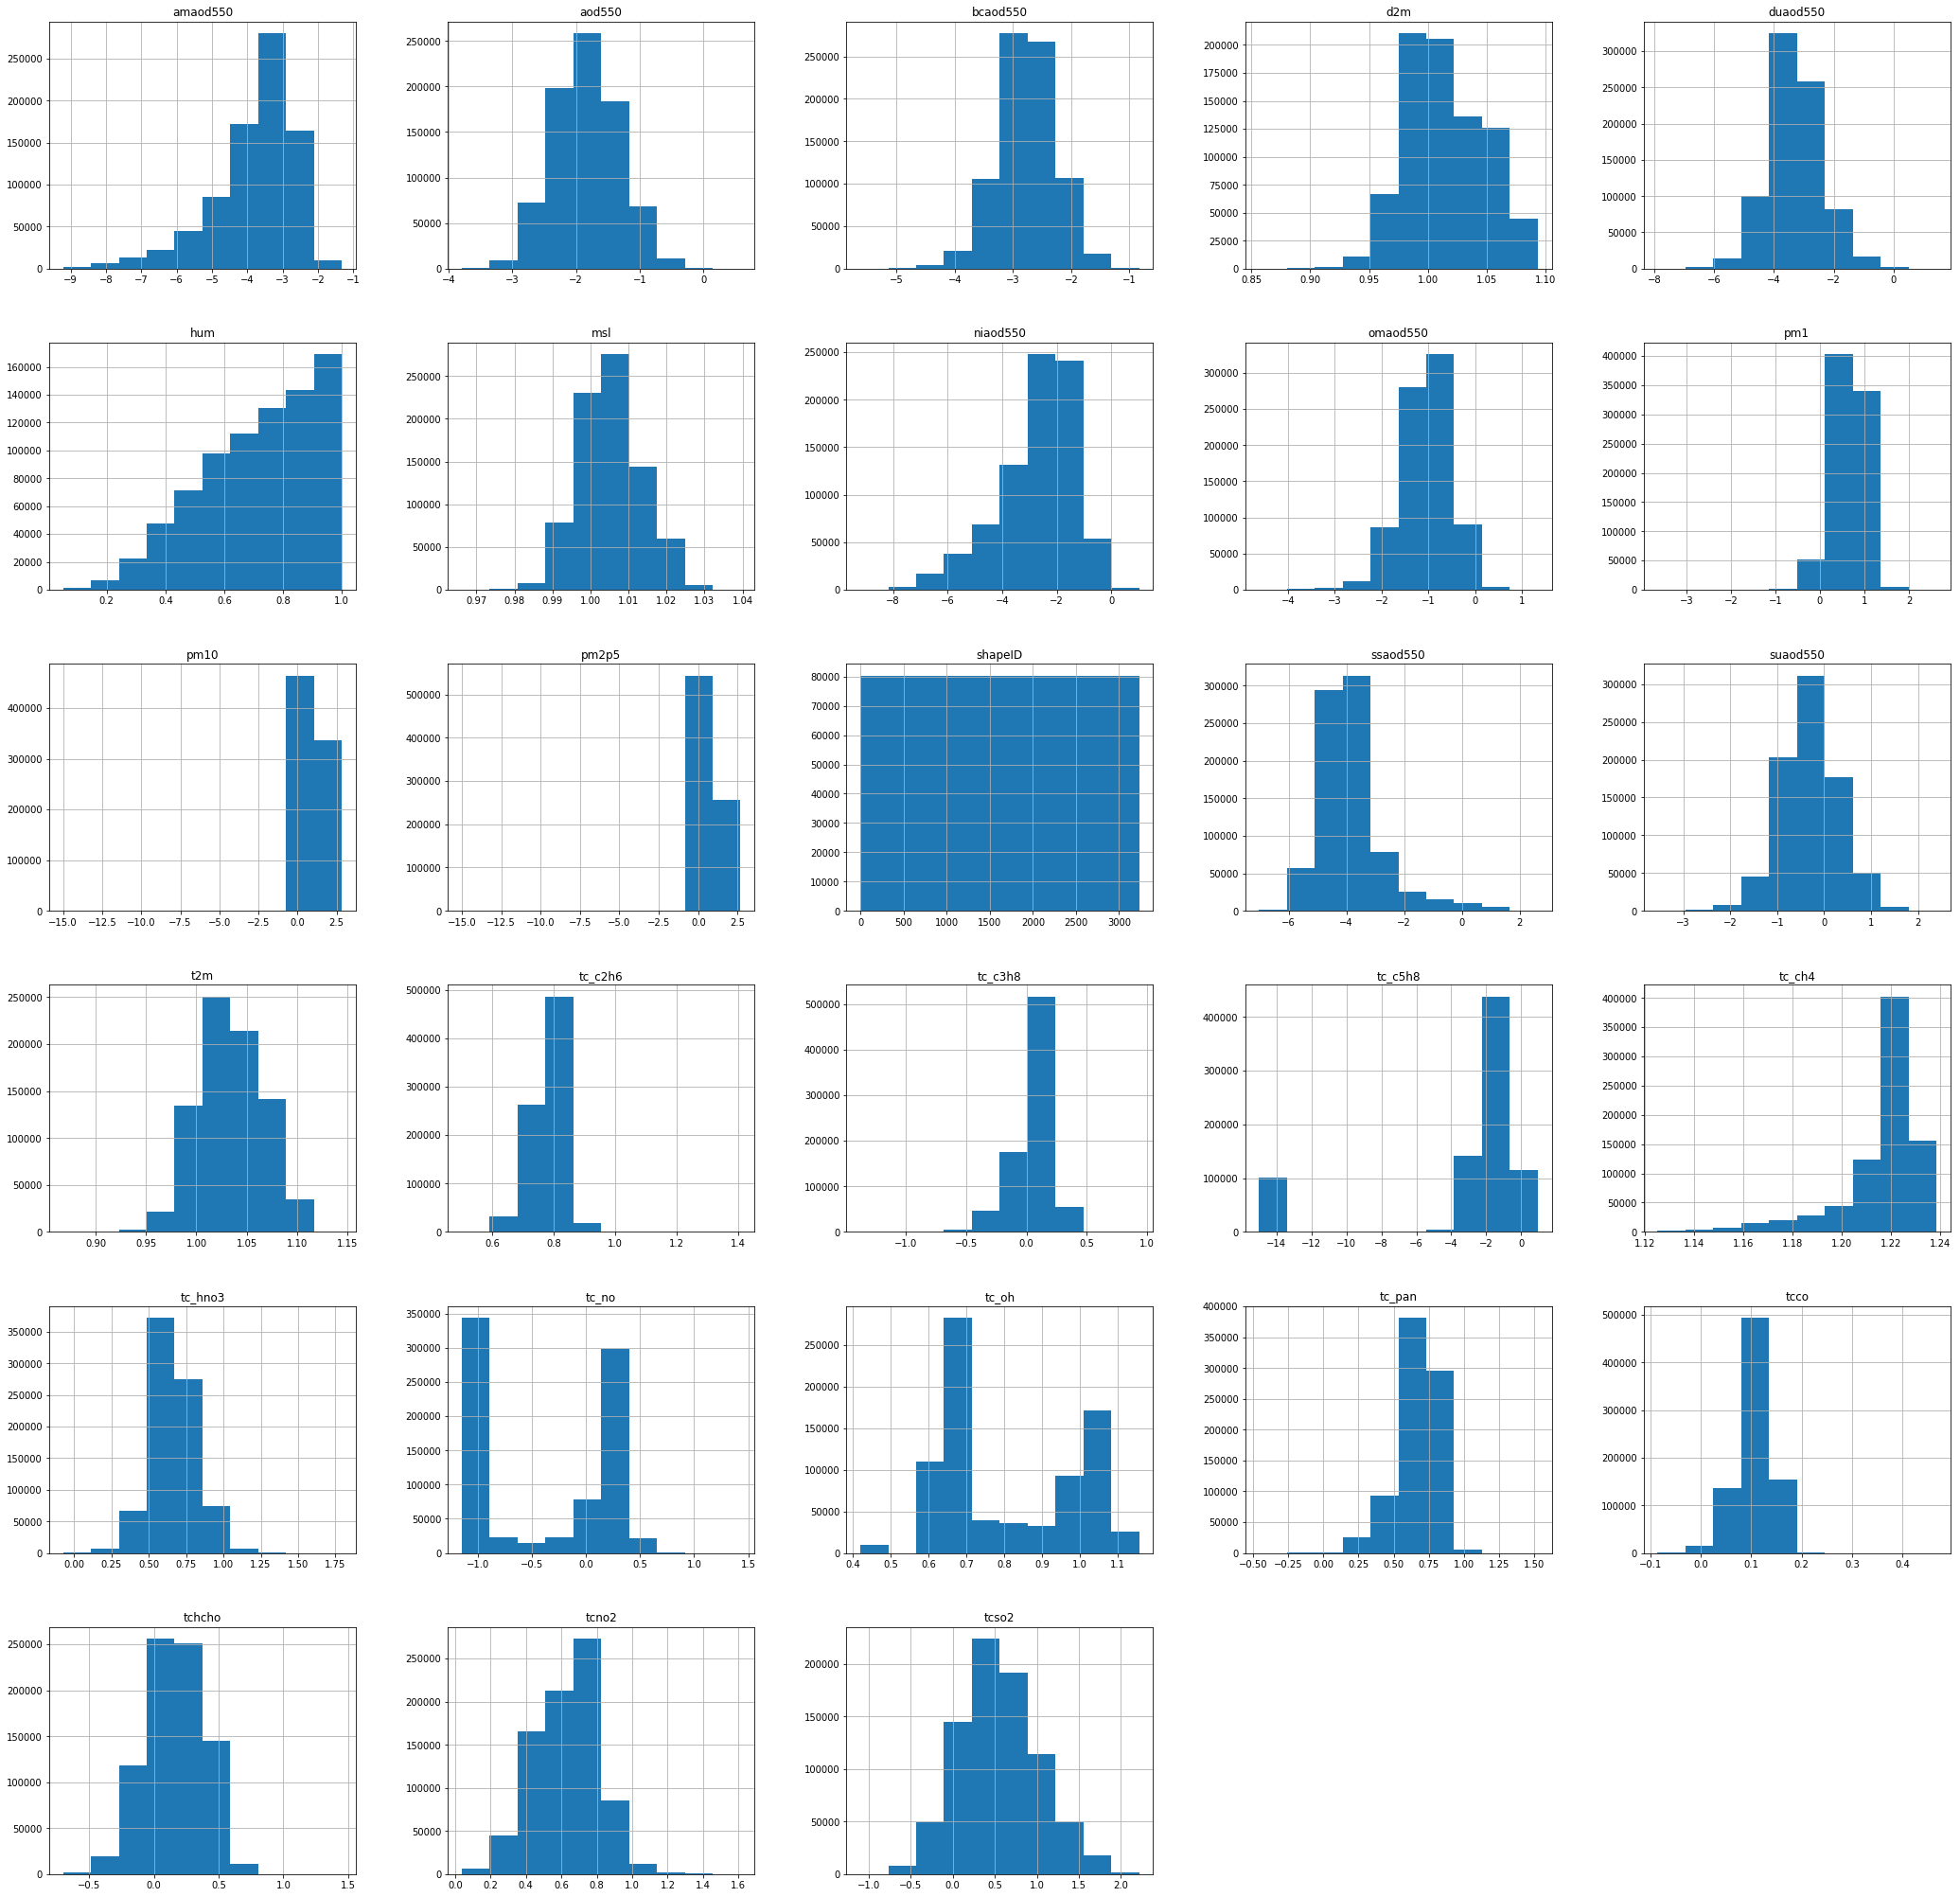

In [7]:
df_std.hist(figsize=(36,36))

#### Plot to see use of PCA

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

def plot_PCA_var(df, columns):
    N_PC = len(col_names)
    data_matrix = scale(np.array(df[columns].values)) #get vals and Standardize for PCA

    explained_variance_by_axis = PCA(n_components=N_PC).fit(data_matrix).explained_variance_ratio_
    cum_variance = np.cumsum(explained_variance_by_axis)

    x = range(1, N_PC+1)
    y = cum_variance

    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(x, y)
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.title("Total explained variance according to N of principle components")
    plt.xlabel("N prinpal components")
    plt.ylabel("% explained variance")
    for a,b in zip(x, y): 
        plt.text(a, b, str(round(b*100,1)))
    plt.show()

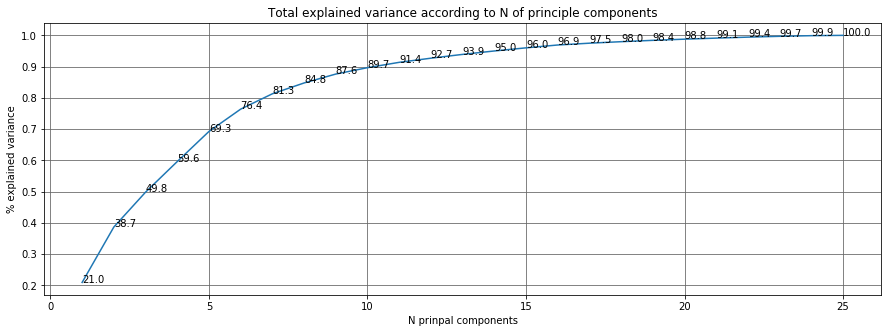

In [9]:
col_names = df_std.columns.drop(["hum", "shapeID", "time", "tc_c5h8"])
plot_PCA_var(df_std, col_names)

We see that at 11 PCs we gather 91% of total $\sigma^2$

In [10]:
N_PC = 11
col_names = df_std.columns.drop(["hum", "shapeID", "time", "tc_c5h8"])
df_std_sorted = df_std.sort_values(by=(["shapeID", "time"]))
data = scale(np.array(df_std_sorted[col_names].values)) #get vals and Standardize for PCA

PCA_model = PCA(n_components=N_PC).fit(data)
x_vars = PCA_model.transform(data)

X = pd.DataFrame(df_std_sorted[["shapeID", "time"]])
for i in range(N_PC):
    X["x"+str(i)] = x_vars[:,i]

print(X)

        shapeID                time        x0        x1        x2        x3  \
0             0 2020-03-01 00:00:00 -1.031924  2.307967  2.214615 -0.791807   
62            0 2020-03-01 03:00:00 -1.937348  0.762541  3.554228 -1.525131   
63            0 2020-03-01 06:00:00 -2.544174  0.197286  3.984245 -1.291405   
64            0 2020-03-01 09:00:00 -2.430425  0.043856  3.290632 -1.045348   
1             0 2020-03-01 12:00:00 -3.060345 -1.547985  0.688214  0.047532   
65            0 2020-03-01 15:00:00 -0.260278 -2.312766  0.158016  1.033674   
66            0 2020-03-01 18:00:00  0.559845 -1.941771 -0.379199  1.496421   
67            0 2020-03-01 21:00:00  0.678170 -1.601264 -0.347755  0.947952   
2             0 2020-03-02 00:00:00 -0.459457 -1.935131  0.774214 -0.231807   
68            0 2020-03-02 03:00:00 -1.301433 -2.189966  0.139172 -1.078324   
69            0 2020-03-02 06:00:00 -1.237966 -2.799992  0.194823 -1.597303   
70            0 2020-03-02 09:00:00 -0.420727 -1.307

In [11]:
X.to_csv(DATA_FOLDER + "X/cams_data.csv")